In [2]:
import praw
from dotenv import dotenv_values

config = dotenv_values(".env")

reddit = praw.Reddit(
    client_id=config["CLIENT_ID"],
    client_secret=config["CLIENT_SECRET"],
    user_agent=config["USER_AGENT"],
)

In [3]:
import re

from nrclex import NRCLex

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def analyze_emotion(text: str) -> str:
    lexicon = NRCLex(clean_text(text))
    emotions = lexicon.affect_frequencies
    dominant_emotion = max(emotions, key=emotions.get)
    return dominant_emotion

In [58]:
from datetime import datetime

subreddit = reddit.subreddit("worldnews")
submissions = []

for post in subreddit.top(time_filter="month", limit=None):
    submissions.append([
        post.title,
        post.num_comments,
        datetime.utcfromtimestamp(post.created_utc),
        post.author,
        post.score,
        post.upvote_ratio,
        post.num_crossposts,
        analyze_emotion(post.title),
    ])

In [59]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

for post in submissions:
    score = analyzer.polarity_scores(clean_text(post[0]))
    del score["compound"]
    post.extend(score.values())

In [60]:
import pandas as pd

df = pd.DataFrame(
    submissions,
    columns=["title", "comments", "created", "author", "upvotes", "upvote_ratio", "crossposts", "emotion", "negative", "neutral", "positive"],
)

In [61]:
df

,title,comments,created,author,upvotes,upvote_ratio,crossposts,emotion,negative,neutral,positive
0,Senior US lawmaker confirms Egypt warned Israe...,3791,2023-10-11 15:55:19,AmatuerNetworkist,34768,0.93,10,fear,0.189,0.811,0.000
1,Israel resumes water supply to southern Gaza a...,5270,2023-10-15 15:33:34,HappyBavarian,33056,0.91,4,positive,0.196,0.804,0.000
2,Residents near Gaza border beg for help: 'They...,9324,2023-10-07 08:37:07,Mazcal,30534,0.87,9,negative,0.190,0.693,0.117
3,Israel says no humanitarian break to Gaza sieg...,13625,2023-10-12 09:06:02,project_95,29971,0.89,7,surprise,0.148,0.671,0.181
4,Hamas official promises: 'We'll repeat Oct. 7 ...,7415,2023-11-01 12:57:50,BinaryPhinary2,28211,0.78,13,fear,0.000,0.657,0.343
...,...,...,...,...,...,...,...,...,...,...,...
994,Ghana plunged into darkness as country faces e...,49,2023-10-30 06:45:59,Relevant_Ninja2251,445,0.95,1,fear,0.412,0.588,0.000
995,Belgium expects to use $2.4 bln in tax on froz...,7,2023-10-11 15:33:31,giuliomagnifico,440,0.96,0,positive,0.000,0.884,0.116
996,Hamas likely cooperates with hackers to stay o...,14,2023-10-20 13:49:17,Silly-avocatoe,435,0.89,0,trust,0.000,1.000,0.000
997,Turkey launches fresh strikes on Kurdish targe...,37,2023-10-07 23:05:49,green_flash,437,0.91,1,fear,0.329,0.563,0.108


<Axes: title={'center': 'Distribution of Emotions on r/GeoPolitics'}, xlabel='emotion', ylabel='count'>

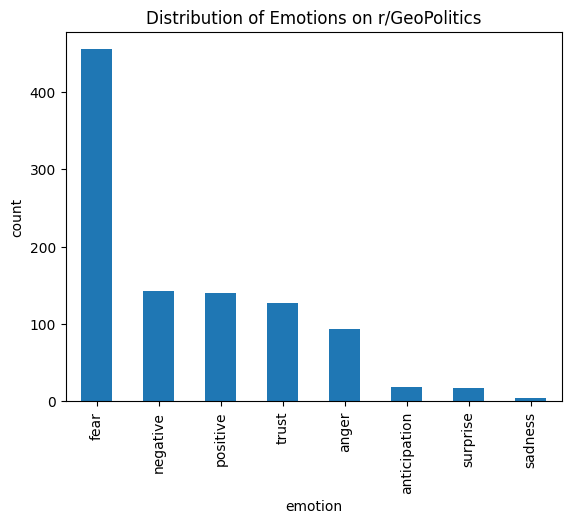

In [62]:
emotion_count = df.emotion.value_counts()
emotion_count.plot.bar(xlabel="emotion", ylabel="count", title="Distribution of Emotions on r/GeoPolitics")